Goal: Create a hierarchical clustering built upon both genotypic and phenotypic information. 

One proposal (40 total features): 
- 20 features for normalized abundance at T0 across native pHs
- 11 features for normalized abundance at T9 across perturbed pHs
- 9 features for structural and sequence-based information:
  - (3) Alpha helix, Beta sheet, Coil proportions
  - (2) Solvent-Accessible surface area (both total and average per residue)
  - (1) Radius of Gyration (compactness)
  - (1) Length
  - (1) Instability Index
  - (1) Isoelectric Point (pI) — pH at which the protein is net neutral




First, I need the ORFs for each of the 60 for which we have a compelete sequence after the first clustering. Then, I will use a cluster map to reduce redudancy, gather the relevant data for each one. 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mgsa.helpers import plot
from mgsa.io import get_data

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


Start over, no conditioning out, but using the incomplete to complete map

In [49]:
KO = 'K00370'
map = '09'
Drug = 'None'

complete_ids = pd.read_csv(f'../out/aaseqs/{KO}/long_complete_orf_ids.txt', header = None)
complete_ids = complete_ids.values

all_ids = pd.read_csv(f'../out/orf_ids/cluster_ids_{map}_{KO}.tsv', sep = '\t', header=None)

map = pd.read_csv(f'../out/aaseqs/{KO}/incomplete_to_complete_seq_mapping.tsv', sep = '\t')
map = map.values

T0data = np.zeros((len(complete_ids), 20))
T9data = np.zeros((len(complete_ids), 10, 11))

for i, id in enumerate(complete_ids):
    got_data = get_data(id, drug = Drug, KO=KO)
    T0data[i] += got_data[0]
    T9data[i] += got_data[1]

print(T9data[:,:,1].shape)

for i, id in enumerate(map[:,0]):
    complete_id = map[i, 1]
    idx = np.where(complete_ids == complete_id)[0][0]
    got_data = get_data(id, drug = Drug)
    T0data[idx] += got_data[0]
    T9data[idx] += got_data[1]






(57, 10)


In [98]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler

strc_data = pd.read_csv(f'../out/structure_analysis/{KO}/structure_metrics_{KO}.tsv', sep='\t')
strc_data = strc_data.values
strc_data = strc_data[:, 1:]#remove the first column (orf names)

scaler = MinMaxScaler()
strc_data = scaler.fit_transform(strc_data)


data_abs = T0data
T0data = T0data / T0data.sum(axis = 1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)

data = T0data 
for i in range(10):
    T9temp = T9data[:,i,:]
    data_abs = np.hstack((data_abs, T9temp))
    T9temp = T9temp / T9temp.sum(axis = 1, keepdims=True)
    T9temp = np.nan_to_num(T9temp, nan = 0)
    data = np.hstack((data, T9temp))
    

pairwise_data = np.load(f'../out/aaseqs/{KO}/long_complete_pwalignment_scores.npy')
print(pairwise_data)
pairwise_data = scaler.fit_transform(pairwise_data)
data = np.hstack((data, pairwise_data))
data_abs = np.hstack((data_abs, pairwise_data))
#data = np.hstack((data, strc_data))


# weights = np.concatenate([
#     np.full(20, 1/np.sqrt(20)),    
#     np.full(110, 1/np.sqrt(110)),  
#     np.full(8, 1/np.sqrt(8))       
# ])


# weights = np.concatenate([
#     np.full(20, 1),    
#     np.full(110, 1),  
#     np.full(57, 0),    
# ])

weights = np.concatenate([
    np.full(20, 0.3),    
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(10, 0.1),  
    np.full(1, 2),
    np.full(57,0.3)
])

weighted_data = data * weights 



[[6505. 2888. 2987. ... 2950. 5906. 2973.]
 [2888. 6662. 3282. ... 4721. 2914. 3331.]
 [2987. 3282. 6539. ... 3258. 3002. 4512.]
 ...
 [2950. 4721. 3258. ... 6743. 2975. 3230.]
 [5906. 2914. 3002. ... 2975. 6519. 3032.]
 [2973. 3331. 4512. ... 3230. 3032. 6674.]]


[18, 35, 41, 48, 50, 16, 43, 46, 56, 42, 47, 24, 29, 22, 51, 40, 32, 2, 9, 38, 23, 34, 7, 13, 12, 36, 17, 8, 30, 33, 39, 31, 20, 49, 10, 55, 27, 0, 52, 5, 44, 1, 6, 25, 45, 3, 14, 28, 21, 4, 54, 11, 37, 26, 53, 15, 19]


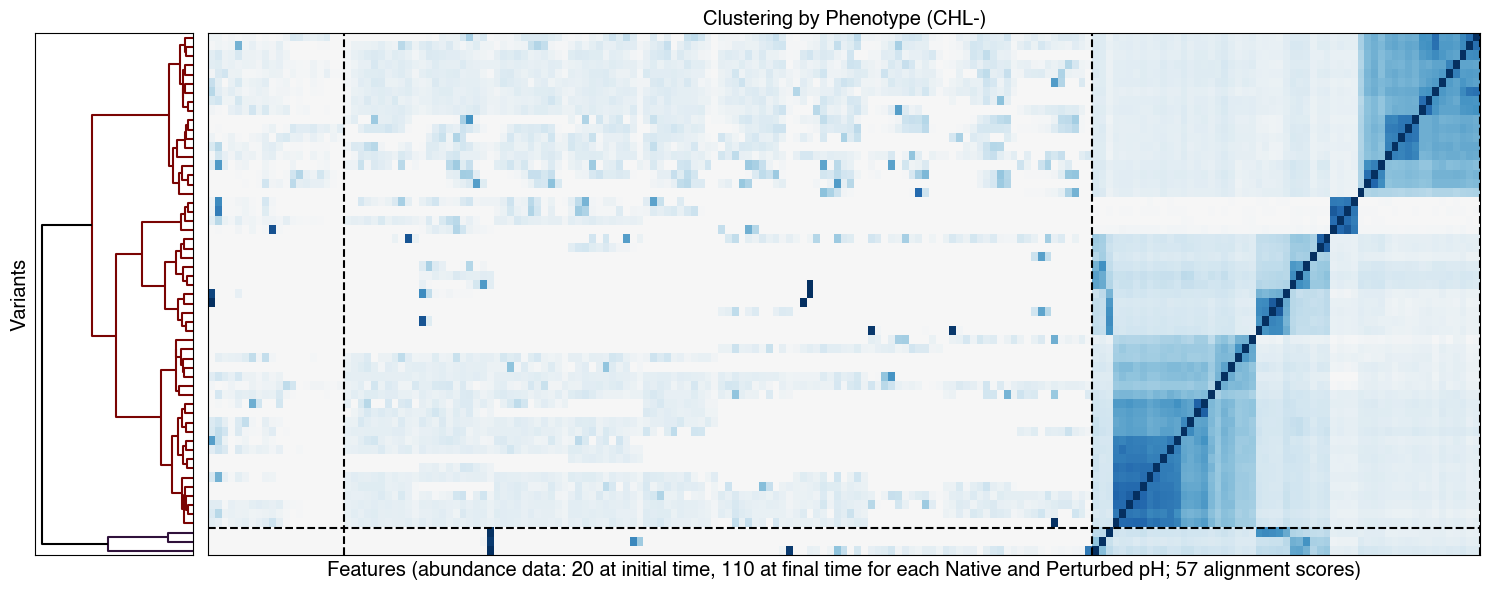

In [99]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex


Z = linkage(weighted_data, method='ward', metric='euclidean')
Z_optimal = optimal_leaf_ordering(Z, pdist(data, metric='euclidean'))

n_clusters = 2
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']

idx_to_cluster = {i: clusters[i] for i in range(len(clusters))}


next_node = len(clusters)
node_to_cluster = {}

for i, (left, right, _, _) in enumerate(Z_optimal):
    left, right = int(left), int(right)
    left_cluster = idx_to_cluster.get(left, node_to_cluster.get(left, -1))
    right_cluster = idx_to_cluster.get(right, node_to_cluster.get(right, -1))
    if left_cluster == right_cluster and left_cluster != -1:
        node_to_cluster[next_node] = left_cluster
    next_node += 1
    
    

#cluster_colors = ['#1f77b4', "#9729E0", "#610a70", "#210bcb"]
cmap = plt.cm.turbo # Or any other colormap (e.g., 'viridis', 'plasma')
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    cluster_id = node_to_cluster.get(link_idx, -1)
    if cluster_id != -1 and cluster_id <= len(cluster_colors):
        return cluster_colors[cluster_id - 1]
    return "#000000"  # default color for unclustered links


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.5, 4]})

dendrogram(Z_optimal,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Variants', fontname='Helvetica', fontsize = 'x-large')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(left=False, bottom=False)

data = np.array(data)

rearranged_data = data[leaf_indices]
col_leaf_indices = leaf_indices+130*np.ones(57, dtype = int)
rearranged_data[:, 130:187] = rearranged_data[:, col_leaf_indices]

im = ax2.imshow(rearranged_data, aspect='auto', cmap='RdBu',
                interpolation='nearest', origin='lower', vmin = -1, vmax = 1)
#plt.colorbar(im, ax=ax2)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    
ax2.axvline(19.5, color='black', linestyle='--')
ax2.axvline(129.5, color='black', linestyle='--')
ax2.axvline(186.5, color='black', linestyle='--')
ax2.set_xticks([])

ax2.set_title('Clustering by Phenotype (CHL-)', fontname='Helvetica', fontsize = 'x-large')
ax2.set_xlabel('Features (abundance data: 20 at initial time, 110 at final time for each Native and Perturbed pH; 57 alignment scores)', fontname='Helvetica', fontsize = 'x-large')

#ax2.set_ylabel('Variants', fontname='Helvetica', fontsize='x-large')

ax2.set_yticks([])
ax2.set_yticks([])
plt.tight_layout()

print(leaf_indices)
    
plt.show()

(57, 187)
(57, 187)
[2]


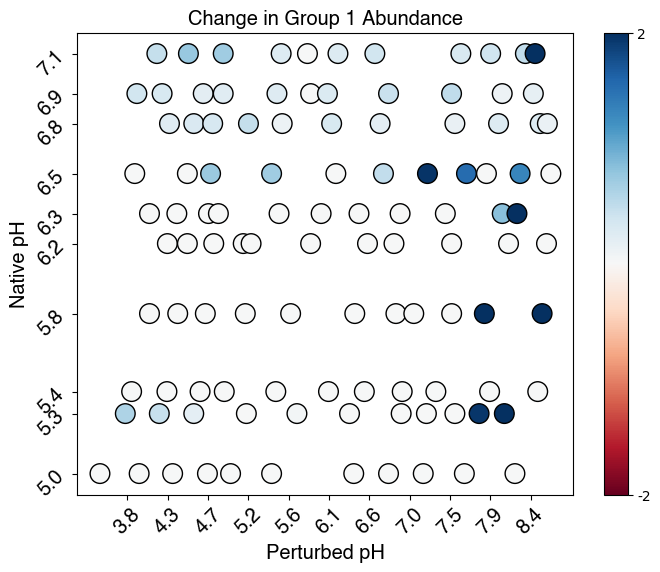

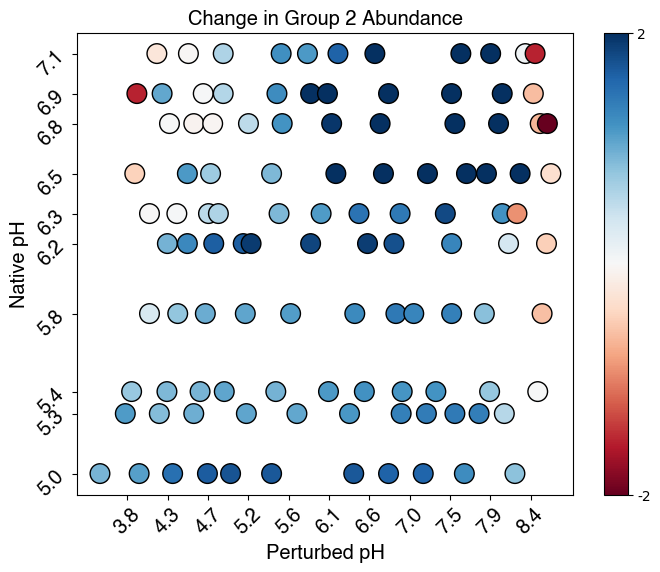

In [100]:

new_data = data_abs[leaf_indices]

print(data.shape)
print(new_data.shape)
print(boundaries)


groups = np.zeros((n_clusters,187))

for i, datum in enumerate(new_data):
    for j in range(1, n_clusters-1):
        if i > boundaries[j - 1] and i < boundaries[j]:
            groups[j] += datum
    if i < boundaries[0]:
        groups[0] += datum
    elif i > boundaries[n_clusters-2]:
        groups[n_clusters-1] += datum




selected = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]

#T0
groups_T0 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(n_clusters):
        groups_T0[j][i] = groups[j][selected][i]
        
# for j in range(n_clusters):
#     plot(groups_T0[j], f'Group {j+1} Abundance before Experiment', vmax = 1)

#T9
groups_T9 = [np.zeros((10, 11)) for _ in range(n_clusters)]

for i in range(10): #native pH
    for j in range(11): #perturbed pH
        for k in range(n_clusters):
            groups_T9[k][i][j] = groups[k][20 + 11*i + j]
            
# for i in range(n_clusters):
#     plot(groups_T9[i],  f'Group {i+1} Abundance after Experiment', vmin = 0, vmax = 1)
        
for i in range(n_clusters):
    plot(np.log((groups_T9[i] + 0.01*np.ones_like(groups_T9[i])) /  (groups_T0[i]+ 0.01 * np.ones_like(groups_T0[i]))), f'Change in Group {i+1} Abundance', vmin = -2, vmax = 2, cmap = 'RdBu')


#change



Below, function for secondary structure classification

0.41462075579218993
0.005389658967763842


Pairwise structure analysis

In [47]:
pairwise_structure = pd.read_csv('../out/structure_analysis/K00370/pairwise_alignments.tsv', sep = '\t', header=None)
pairwise_structure = pairwise_structure.values

orf_list = pd.read_csv('../out/aaseqs/K00370/long_complete_orf_ids.txt', header=None)
orf_list = orf_list.values
orf_list = [orf[0] for orf in orf_list]

pairwise = np.zeros((len(orf_list), len(orf_list)))

print(len(pairwise_structure))

print(pairwise_structure)
for orf in orf_list:
    print(orf)

for row in pairwise_structure:
    row_idx = orf_list.index(row[0])
    col_idx = orf_list.index(row[1])
    pairwise[row_idx][col_idx] = row[2]
    pairwise[col_idx][row_idx] = row[2]
    
plt.imshow(pairwise)

1654
[['orfid1' 'orfid2' 'rmsd' ... 'num_aligned_atoms_prerefine'
  'raw_alignment_score' 'num_aligned_residues']
 ['1Q16' 'Soil11.scaffold_211583530_c1_6' '0.3214247524738312' ... '9067'
  '4762.5' '1235']
 ['1Q16' 'Soil11.scaffold_431547323_c1_2' '0.5822731256484985' ... '8100'
  '2961.5' '1178']
 ...
 ['T0.scaffold_273218771_c1_2' 'T0.scaffold_786865677_c1_2'
  '0.4444236755371094' ... '14930' '3363.5' '1188']
 ['T0.scaffold_273218771_c1_2' 'T0.scaffold_961428012_c1_71'
  '0.5998002290725708' ... '14811' '3155.0' '1156']
 ['T0.scaffold_786865677_c1_2' 'T0.scaffold_961428012_c1_71'
  '0.552955150604248' ... '14679' '3075.5' '1157']]
Soil11.scaffold_431547323_c1_2
Soil11.scaffold_587233302_c1_1
Soil11.scaffold_65427810_c1_20
Soil11.scaffold_211583530_c1_6
Soil12.scaffold_266712765_c1_2
Soil14.scaffold_576820813_c1_40
Soil14.scaffold_280216268_c1_12
Soil14.scaffold_465502786_c1_2
Soil14.scaffold_596019752_c1_119
Soil15.scaffold_116822102_c1_19
Soil15.scaffold_175810641_c1_3
Soil15.scaf

ValueError: 'orfid1' is not in list

In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

strc_data = pd.read_csv(f'../out/structure_analysis/{KO}/structure_metrics_{KO}.tsv', sep='\t')
strc_data = strc_data.values
strc_data = strc_data[:, 1:]#remove the first column (orf names)

scaler = MinMaxScaler()
strc_data = scaler.fit_transform(strc_data)



T0data = T0data / T0data.sum(axis = 1, keepdims=True)
T0data = np.nan_to_num(T0data, nan = 0)

data = T0data 
for i in range(10):
    T9temp = T9data[:,i,:]
    T9temp = T9temp / T9temp.sum(axis = 1, keepdims=True)
    T9temp = np.nan_to_num(T9temp, nan = 0)
    data = np.hstack((data, T9temp))
    

pairwise_data = np.load(f'../out/aaseqs/{KO}/long_complete_pwalignment_scores.npy')
print(pairwise_data)
pairwise_data = scaler.fit_transform(pairwise_data)
data = np.hstack((data, pairwise_data))

pairwise = scaler.fit_transform(pairwise)
plt.imshow(pairwise)
data = np.hstack((data, pairwise)) #add pairwise structure data 

weights = np.concatenate([
    np.full(20, 1),    
    np.full(110, 1),  
    np.full(57,1),
    np.full(57, 1)  
])

weighted_data = data * weights 


[[6505. 2888. 2987. ... 2950. 5906. 2973.]
 [2888. 6662. 3282. ... 4721. 2914. 3331.]
 [2987. 3282. 6539. ... 3258. 3002. 4512.]
 ...
 [2950. 4721. 3258. ... 6743. 2975. 3230.]
 [5906. 2914. 3002. ... 2975. 6519. 3032.]
 [2973. 3331. 4512. ... 3230. 3032. 6674.]]


NameError: name 'pairwise' is not defined

IndexError: index 215 is out of bounds for axis 1 with size 187

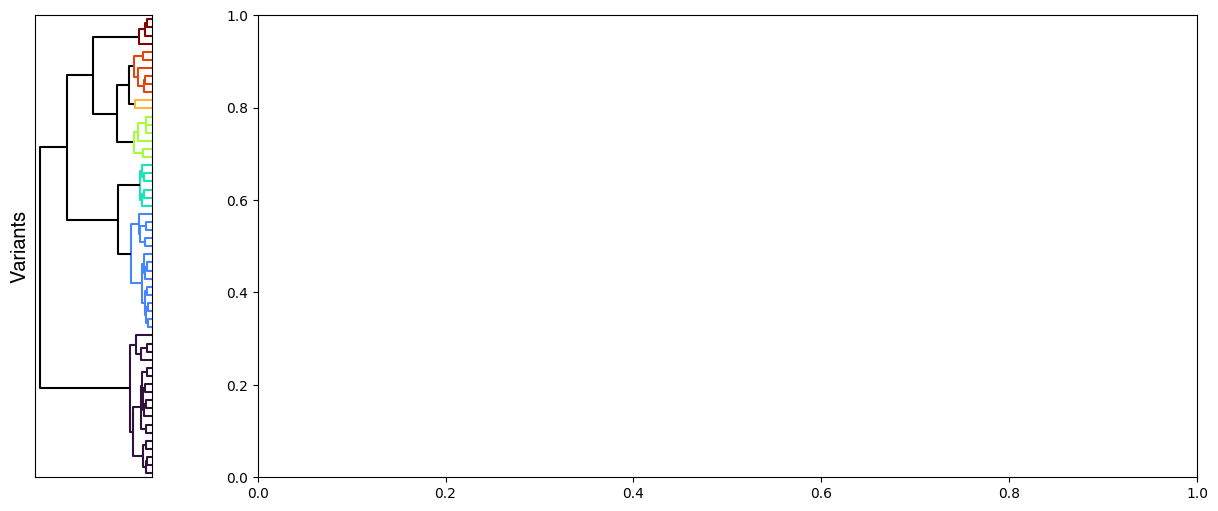

In [45]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, optimal_leaf_ordering
from scipy.spatial.distance import pdist
from matplotlib.colors import to_hex


Z = linkage(weighted_data, method='ward', metric='euclidean')
Z_optimal = optimal_leaf_ordering(Z, pdist(data, metric='euclidean'))

n_clusters = 7
clusters = fcluster(Z_optimal, t=n_clusters, criterion='maxclust')

dendro = dendrogram(Z_optimal, no_plot=True)
leaf_indices = dendro['leaves']

idx_to_cluster = {i: clusters[i] for i in range(len(clusters))}


next_node = len(clusters)
node_to_cluster = {}

for i, (left, right, _, _) in enumerate(Z_optimal):
    left, right = int(left), int(right)
    left_cluster = idx_to_cluster.get(left, node_to_cluster.get(left, -1))
    right_cluster = idx_to_cluster.get(right, node_to_cluster.get(right, -1))
    if left_cluster == right_cluster and left_cluster != -1:
        node_to_cluster[next_node] = left_cluster
    next_node += 1
    
    

#cluster_colors = ['#1f77b4', "#9729E0", "#610a70", "#210bcb"]
cmap = plt.cm.turbo # Or any other colormap (e.g., 'viridis', 'plasma')
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    cluster_id = node_to_cluster.get(link_idx, -1)
    if cluster_id != -1 and cluster_id <= len(cluster_colors):
        return cluster_colors[cluster_id - 1]
    return "#000000"  # default color for unclustered links


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.5, 4]})

dendrogram(Z_optimal,
           orientation='left',
           ax=ax1,
           color_threshold=max(Z_optimal[-n_clusters+1, 2], 0.1),
           link_color_func=color_func,
           above_threshold_color='k')

ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('Variants', fontname='Helvetica', fontsize = 'x-large')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.tick_params(left=False, bottom=False)

data = np.array(data)

rearranged_data = data[leaf_indices]
col_leaf_indices = leaf_indices+130*np.ones(57, dtype = int)
rearranged_data[:, 130:187] = rearranged_data[:, col_leaf_indices]
col_leaf_indices = leaf_indices+187*np.ones(57, dtype = int)
rearranged_data[:, 187:244] = rearranged_data[:, col_leaf_indices]

im = ax2.imshow(rearranged_data, aspect='auto', cmap='RdBu',
                interpolation='nearest', origin='lower', vmin = -1, vmax = 1)
#plt.colorbar(im, ax=ax2)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    
ax2.axvline(19.5, color='black', linestyle='--')
ax2.axvline(129.5, color='black', linestyle='--')
ax2.axvline(186.5, color='black', linestyle='--')
ax2.set_xticks([])

ax2.set_title('Clustering by Phenotype and Genotype (CHL-)', fontname='Helvetica', fontsize = 'x-large')
ax2.set_xlabel('Features (abundance data: 20 at initial time, 110 at final time for each Native and Perturbed pH; \n 57 genotype alignment scores; 57 structural distance scores)', fontname='Helvetica', fontsize = 'x-large')

#ax2.set_ylabel('Variants', fontname='Helvetica', fontsize='x-large')

ax2.set_yticks([])
ax2.set_yticks([])
plt.tight_layout()

print(leaf_indices)
    
plt.show()

Create a text file and readme for v1 clusters

In [ ]:
#created without any structural information, weighting phenotype and genotype equally

v1_clusters = []
for i in range(len(orf_list)):
    #print(orf_list[i], leaf_indices[i])
    cluster = 0
    if leaf_indices[i] < boundaries[0] + 0.5:
            cluster = 1
    for j in range(1, len(boundaries)):
        if leaf_indices[i] > boundaries[j-1] + 0.5 and leaf_indices[i] < boundaries[j]+0.5:
            cluster = j + 1
    j = len(boundaries) - 1
    if leaf_indices[i] > boundaries[j]+0.5:
        cluster = 7
    v1_clusters.append([orf_list[56-i], cluster])
    

for element in v1_clusters:
    print(element)

[np.str_('T0.scaffold_273218771_c1_2'), 3]
[np.str_('T0.scaffold_961428012_c1_71'), 1]
[np.str_('T0.scaffold_172278247_c1_4'), 7]
[np.str_('T0.scaffold_786865677_c1_2'), 7]
[np.str_('Soil9.scaffold_711597457_c1_4'), 2]
[np.str_('Soil9.scaffold_209032411_c1_3'), 3]
[np.str_('Soil9.scaffold_175774837_c1_4'), 1]
[np.str_('Soil9.scaffold_816779774_c1_14'), 6]
[np.str_('Soil9.scaffold_766455321_c1_2'), 4]
[np.str_('Soil9.scaffold_98038919_c1_19'), 1]
[np.str_('Soil6.scaffold_95998780_c1_2'), 7]
[np.str_('Soil6.scaffold_460055642_c1_2'), 4]
[np.str_('Soil6.scaffold_312871021_c1_4'), 4]
[np.str_('Soil6.scaffold_86801766_c1_2'), 2]
[np.str_('Soil5.scaffold_13272894_c1_8'), 7]
[np.str_('Soil5.scaffold_434220697_c1_2'), 1]
[np.str_('Soil5.scaffold_559257041_c1_1'), 1]
[np.str_('Soil5.scaffold_82918708_c1_12'), 1]
[np.str_('Soil5.scaffold_249001418_c1_2'), 4]
[np.str_('Soil5.scaffold_416434691_c1_48'), 7]
[np.str_('Soil5.scaffold_120605214_c1_7'), 1]
[np.str_('Soil5.scaffold_549495455_c1_6'), 7]


[3, 1, 7, 7, 2, 3, 1, 6, 4, 1, 7, 4, 4, 2, 7, 1, 1, 1, 4, 7, 1, 7, 3, 5, 5, 6, 5, 3, 7, 1, 1, 6, 6, 2, 1, 5, 1, 5, 1, 4, 6, 1, 1, 4, 7, 6, 5, 7, 7, 4, 4, 2, 7, 7, 7, 7, 7]


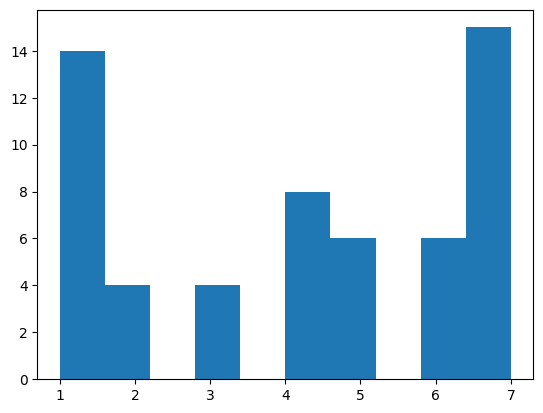

In [ ]:
values = [item[1] for item in v1_clusters]
plt.hist(values)
print(values)

with open("../out/groups/assignments_v1.tsv", 'w') as f:
    for row in v1_clusters:
        f.write(f"{row[0]} {row[1]}\n")
